## Importing image

In [3]:
from tensorflow.keras import preprocessing

2022-11-28 15:45:32.927600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 15:45:33.281648: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-28 15:45:33.295596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-28 15:45:33.295611: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [5]:
img = preprocessing.image.load_img("/mnt/c/Users/ellad/Downloads/small_XNEIGJ2C.jpg")

In [89]:
img_x = preprocessing.image.load_img("/mnt/c/Users/ellad/Downloads/small_ZOH7958V.jpg")

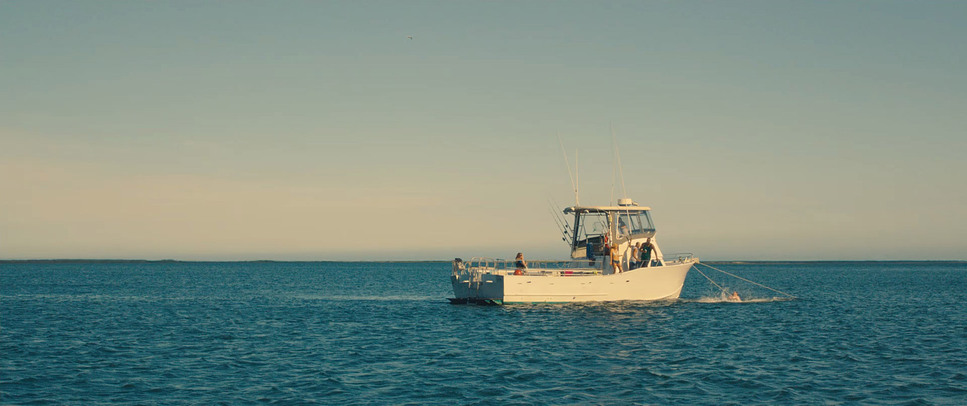

In [90]:
img_x

In [6]:
import numpy as np

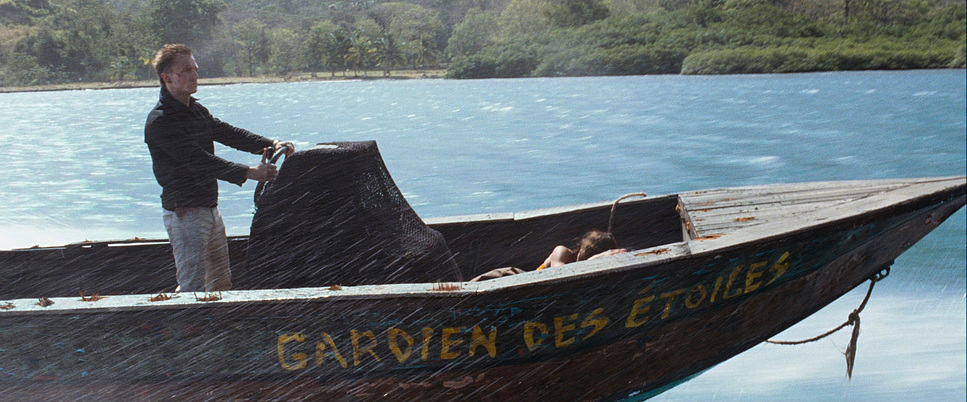

In [7]:
img

## Convert to array - UNNECESSARY


In [9]:
# img_array.shape

(402, 967, 3)

In [91]:
# img_array_x = np.array(img_x)

## Resize image


This also converts to array

In [94]:
from tensorflow.image import resize

In [95]:
img_2 = resize(img, [28,28])/255
img_x_2 = resize(img_x, [28,28])/255

In [96]:
img_2.shape

TensorShape([28, 28, 3])

In [98]:
img_x_2.shape

TensorShape([28, 28, 3])

In [99]:
from matplotlib import pyplot as plt

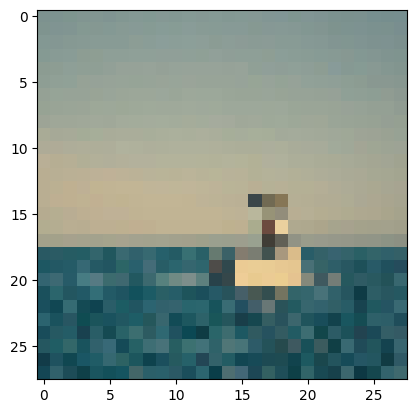

In [101]:
plt.imshow(img_x_2)

## Encoder

1. Build a full autoencoder 
2. Train images on full autoencoder
3. Use scraped images on just encoder.predict to encode them into latent space
4. Use user input on just encoder.predict to encode it into the latent space

In [70]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_encoder(latent_dimension):
    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()
    
    encoder.add(Conv2D(8, (2,2), input_shape=(28, 28, 3), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(16, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(32, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))     

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder

In [71]:
encoder = build_encoder(2)
encoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 27, 27, 8)         104       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 16)        528       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 6, 6, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 32)          2080      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 2, 2, 32)        

In [72]:
encoder.compile(loss='mse',
                  optimizer='adam')

In [73]:
img_2.shape

TensorShape([28, 28, 3])

In [74]:
encoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 27, 27, 8)         104       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 16)        528       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 6, 6, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 32)          2080      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 2, 2, 32)        

In [102]:
img_list = np.array([img_2, img_x_2])

In [103]:
img_list.shape

(2, 28, 28, 3)

In [104]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

def build_decoder(latent_dimension):
    # $CHALLENGIFY_BEGIN
    decoder = Sequential()
    
    decoder.add(Dense(7*7*8, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((7, 7, 8)))  # no batch axis here
    decoder.add(Conv2DTranspose(8, (2, 2), strides=2, padding='same', activation='relu'))

    decoder.add(Conv2DTranspose(3, (2, 2), strides=2, padding='same', activation='relu'))
    return decoder

In [79]:
decoder = build_decoder(2)
decoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 392)               1176      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 8)           0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 8)        264       
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 3)        99        
 ranspose)                                                       
                                                                 
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
_________________________________________________________________


In [80]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

def build_autoencoder(encoder, decoder):
    inp = Input((28, 28,3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

In [81]:
autoencoder = build_autoencoder(encoder, decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 sequential_7 (Sequential)   (None, 2)                 2970      
                                                                 
 sequential_9 (Sequential)   (None, 28, 28, 3)         1539      
                                                                 
Total params: 4,509
Trainable params: 4,509
Non-trainable params: 0
_________________________________________________________________


In [82]:
def compile_autoencoder(autoencoder):
    # $CHALLENGIFY_BEGIN
    autoencoder.compile(loss='mse',
                  optimizer='adam')

In [83]:
compile_autoencoder(autoencoder)
# autoencoder.fit(img_list, img_list, epochs = 20)

In [105]:
autoencoder.fit(img_list, img_list, epochs = 20)

Epoch 1/20
1/1 [==============================] - 0s 20ms/step - loss: 0.2411
Epoch 2/20
1/1 [==============================] - 0s 12ms/step - loss: 0.2392
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 0.2373
Epoch 4/20
1/1 [==============================] - 0s 12ms/step - loss: 0.2353
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.2334
Epoch 6/20
1/1 [==============================] - 0s 14ms/step - loss: 0.2314
Epoch 7/20
1/1 [==============================] - 0s 13ms/step - loss: 0.2294
Epoch 8/20
1/1 [==============================] - 0s 9ms/step - loss: 0.2274
Epoch 9/20
1/1 [==============================] - 0s 8ms/step - loss: 0.2254
Epoch 10/20
1/1 [==============================] - 0s 9ms/step - loss: 0.2234
Epoch 11/20
1/1 [==============================] - 0s 9ms/step - loss: 0.2213
Epoch 12/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2192
Epoch 13/20
1/1 [==============================] - 0s 9ms/step - 

In [106]:
autoencoder.evaluate

<bound method Model.evaluate of <keras.engine.functional.Functional object at 0x7fc0c0266620>>

In [110]:
prediction = encoder.predict(img_list)

1/1 [==============================] - 0s 18ms/step


In [114]:
prediction

array([[-0.99979824, -0.99970627],
       [-0.99918514, -0.99821043]], dtype=float32)

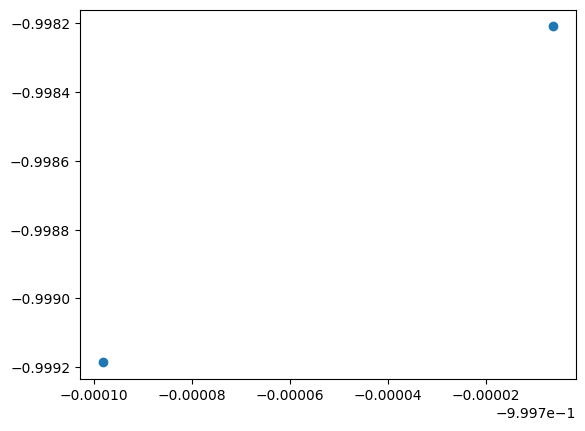

In [120]:
plt.scatter(prediction[0], prediction[1])

In [127]:
from google.cloud import storage
from urllib.request import urlopen


client = storage.Client()


url = "https://shotdeck.com/assets/images/stills/thumb/small_981SHQ8T.jpg"
filedata = urlopen(url)
datatoupload = filedata.read()
new_title = url.split("/")
title = new_title[-1].strip(".jpeg")
bucket = client.get_bucket('le-wagon-bucket-ella')
blob = storage.Blob(title, bucket)
blob.upload_from_string(datatoupload)